# Making $kNN$ more general

In [1]:
%%capture
%run 03_knn_eval.ipynb

Below, we will also need a 3D plotting library:

In [2]:
from mpl_toolkits.mplot3d import Axes3D

Our examples above were perhaps not very realistic: we often have more than two attributes, and need to know how to deal with them.  

## Distance 

We will extend $kNN$ below, but first note that at its core is a measure of *distance*.  In particular **Euclidean Distance**, $D$, which is just the "straight line" distance between two points. It is defined as

> $$
D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}
$$

Here, $x_0, y_0$ is our first point, and $x_1, y_1$ is our second point.  The dimensions $x$ and $y$ correspond to two attributes which we were using to plot the data above.  To see the logic of this distance measure, we can simulate a couple of points: 

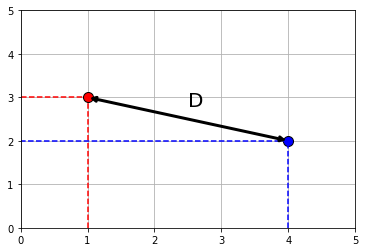

In [3]:
point_1 = np.array([1,3])
point_2 = np.array([4,2])
plt.grid()
plt.scatter(point_1[0], point_1[1], color="r", ec="black", zorder=2, s=100)
plt.scatter(point_2[0], point_2[1], color="b", ec="black", zorder=2, s=100)
plt.plot([1,1],[0,3] , linestyle="--" , color="red")
plt.plot([0,1],[3,3] , linestyle="--" , color="red")
plt.plot([4,4],[0,2] , linestyle="--" , color="blue")
plt.plot([4,0],[2,2] , linestyle="--" , color="blue")
plt.annotate('', xy=(1, 3), xytext=(4, 2),
            arrowprops=dict(arrowstyle='<->', color='black', lw=3))
plt.text(2.5, 2.8, "D", fontsize=20)
plt.xlim(0,5)
plt.ylim(0,5)
plt.show()

Clearly, $D$ is the hypotenuse of a right triangle.  As such, we know its $\mbox{length}^2$ must be the sum of the squares of the other two sides. So:

$$
(x_0-x_1)^2 + (y_0-y_1)^2
$$

And specifically: 

$$
(4-1)^2 + (3-2)^2 = 9 + 1 =10
$$

If $D^2 = 10$, then $D=\sqrt{10}$ or around 3.16.  We can "confirm" this by returning to the function we built earlier: 

In [4]:
def distance(point1, point2):
    """The distance between two arrays of numbers."""
    return np.sqrt(np.sum((point1 - point2)**2))

and calling

In [5]:
distance(point_1, point_2)

3.1622776601683795

As we will see below, this also works when the points have more than two dimensions.  But first, let's return to our running example, and look at what this understanding of distance for $kNN$ implies. 

###  5-Nearest Neighbors
We return to our problem of classifying a new patient in Hemoglobin/Glucose attribute space:

In [6]:
new_patient = np.array([0, 1.1])

ckd_attributes = std_status[['Hemoglobin', 'Glucose']]

We define a new function `distance_from_new_patient` that is as its name suggests: it calculates the *distance* of the new patient's attributes from the attributes of a given row in the table of observations.  We will `apply` this function, such that we get the distance of our patient from *every* row in the data.  Then, we add those distances as a new variable to our (original) data.

In [7]:
def distance_from_new_patient(row):
    """Returns distance between new patient and a row of the attributes table"""
    return distance(new_patient, np.array(row))

distances = ckd_attributes.apply(distance_from_new_patient, axis=1)

std_status_w_distances = std_status.copy(deep=True)
std_status_w_distances["Distance from New Patient"] = distances

If we sort these observations by the distances we calculated, we have an order data set from closest to furthest from our new patient:

In [8]:
sorted_by_distance = std_status_w_distances.sort_values(by=['Distance from New Patient'])

We can obtain the $k$ nearest neighbors by simply requesting the first $k$ rows of this sorted data. For the *5* nearest neighbors, we do:

In [9]:
patient_5_nn = sorted_by_distance.take(np.arange(5))
patient_5_nn

Class  Hemoglobin   Glucose  White Blood Cell Count    status  \
14       1    0.839750  1.215099                1.291014       CKD   
35       1   -0.970162  1.276890               -0.345191       CKD   
84       0   -0.030400  0.087407               -0.184779  CKD free   
152      0    0.143630  0.087407                0.328540  CKD free   
6        1   -0.413266  2.049282                0.360623       CKD   

     Distance from New Patient  
14                    0.847601  
35                    0.986156  
84                    1.013049  
152                   1.022728  
6                     1.035338

Looking down the `Class` column, the *majority* vote is for CKD.  To visualize the result, we can draw a circle around our new patient such that its radius is the distance to the 5th furthest observation.  This circle will incorporate the first five $NN$s, and no more.

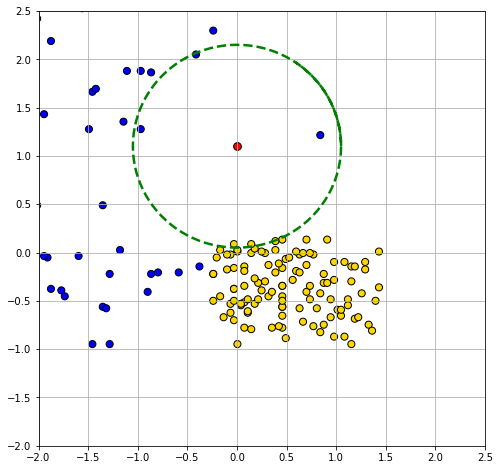

In [10]:
plt.figure(figsize=(8,8))
plt.scatter(std_status['Hemoglobin'], std_status['Glucose'],  
            color= std_status['status'].map(colors),  s=50, edgecolor="black")
plt.grid()
plt.scatter(new_patient.item(0), new_patient.item(1), color='red', s=60, edgecolor="black")

radius = patient_5_nn['Distance from New Patient'].values.flatten()[4] + 0.014 
theta = np.arange(0, 2*np.pi+1, 2*np.pi/200)

plt.plot(radius*np.cos(theta)+new_patient.item(0), radius*np.sin(theta)+new_patient.item(1), 
        color='g', lw=2.5, linestyle='dashed');
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5);

## Multiple attributes
A nice feature of Euclidean distance is that it can, in principle, incorporate any number of attributes.  That is, if $m$ is the number of attributes, $m$ can be 2, 100, 2000, 100000 etc.  The formula becomes: 

$$
D(\mathbf{p},\mathbf{q}) = \sqrt{ (p_0-q_0)^2 + (p_1-q_1)^2+ \ldots +(p_m - q_m)^2 }
$$

Here $\mathbf{p}$ is the first row of data (point); $\mathbf{q}$ is the second row of data (point).  That is, $\mathbf{p}$ is an observation with $m$ attributes $\mathbf{p}=p_0,p_1\ldots p_m$. And  $\mathbf{q}$ is also an observation with $m$ attributes $\mathbf{q}=q_0,q_1\ldots q_m$.

To show *why* moving beyond two attributes is (often) helpful, consider a problem of trying to categorize bank notes into `Counterfeit` or `Real` based on two features: `WaveletSkew` and `Entropy` (don't worry about what these features mean!). We'll read in the data, and color code it: blue if counterfeit, and yellow if real.

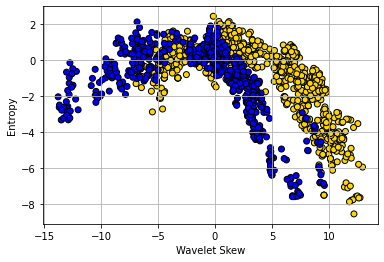

In [11]:
banknotes = pd.read_csv("data/banknote.csv")
colors_bank = {1:'blue', 0 :'gold'}
counter_map = {1:'Counterfeit', 0:'real'}
counter = banknotes['Class'].map(counter_map)
banknotes["status"] = counter


scatter = plt.scatter(banknotes['WaveletSkew'], banknotes['Entropy'], 
                      color=banknotes['Class'].map(colors_bank), 
                        edgecolor="black")

plt.xlabel("Wavelet Skew")
plt.ylabel("Entropy") 
plt.grid()
plt.show()

The boundary here is not obvious: it looks like notes with high Skew and low Entropy are real, but there is a lot of overlap. Let's add some different variables---Wavelet Variance and Wavelet Kurtosis---to our original Wavelet Skew.  

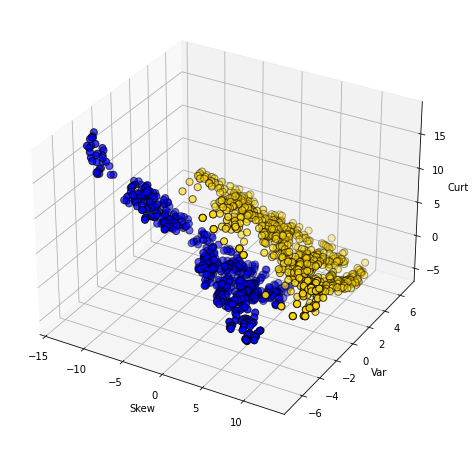

In [12]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes['WaveletSkew'], 
           banknotes['WaveletVar'], 
           banknotes['WaveletCurt'], 
           color= banknotes['Class'].map(colors_bank), edgecolor="black", s=50);
ax.set_xlabel("Skew")
ax.set_ylabel("Var")
ax.set_zlabel("Curt");

Clearly, `WaveletVar` does a good job of dividing the categories, and that will help with classification.

## Building a $kNN$ classifier

To reiterate, for a given application, the $kNN$ algorithm is very simple.  We begin with a data set where we already know the classes of the observations. We are handed a new data point, which is just a vector (a set) of *attributes*. We then need to: 
1. find the closest $k$ neighbors of that new observation
2. obtain the classes of those $k$ neighbors and do a *majority* vote
3. take that majority class as the prediction of our new point.

To see this in action, we will use data on wine.  In particular, we will have a binary outcome class and a total of 13 attributes to help predict this class. In our initial data set, we will have 178 observations.

In [13]:
wine = pd.read_csv('data/wine.csv')

For us, the class of interest is the `Cultivar` which is currently 1,2 or 3. We will change the name of this variable to `Class` and recode it to binary: if `Cultivar` is 1, the class is 1, but otherwise zero. We will put this information back into the original data.

In [14]:
wine_class = wine['Cultivar'] 
wc = wine_class.replace([2,3],0)
wine = wine.rename(columns={'Cultivar': 'Class'})

wine["Class"] = wc
wine.head()

Class  Alcohol  Malic acid   Ash  Alcalinity of ash    Magnesium  \
0      1    14.23        1.71  2.43                 15.6        127   
1      1    13.20        1.78  2.14                 11.2        100   
2      1    13.16        2.36  2.67                 18.6        101   
3      1    14.37        1.95  2.50                 16.8        113   
4      1    13.24        2.59  2.87                 21.0        118   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color intensity   Hue  OD280/OD315 of diluted wines  Proline              
0             5.64  1.04                          3.92                 1065  
1             4.38  1.05                          3.40                 1050  
2             5.68  1.03                          3.17                 1185  
3             7.80  0.86                          3.45                 1480  
4             4.32  1.04                          2.93                  735

We can ask about distances between observations using the functions we defined above, and dropping the `Class` variable to make sure we are only checking distances between *attributes*:

In [15]:
wine_attributes = wine.drop(columns='Class')
distance(wine_attributes.iloc[0,],  wine_attributes.iloc[177,])

506.05936766351834

Suppose now we have a new wine and want to classify it.  To see how this might work, we will first suppose that the new wine is simply the first entry in our data.  Let's get the $5NN$ prediction for that "new" wine:

In [16]:
new_wine = wine.drop(['Class'], axis=1).iloc[0,]
classify(wine, new_wine, 5)

1

Note that all `classify` does is take a majority vote of the classes of the nearest neighbors. What about classifying a "really" new wine? Well, a wine is just some attributes (from our perspective) so let's create one and make it into a data frame:

In [17]:
new_observation = {
    "Alcohol":[14.23], 
    "Malic acid":[4.0], 
    "Ash": [2.70], 
    "Alcalinity of ash":[25], 
    "Magnesium":[96], 
    "Total phenols":[2.00], 
    "Flavanoids":[0.78], 
    "Nonflavanoid phenols":[0.55], 
    "Proanthocyanins":[1.35], 
    "Color intensity":[9.6], 
    "Hue":[0.65], 
    "OD280/OD315 of diluted wines":[1.4], 
    "Proline":[560] }

new_ob = pd.DataFrame(new_observation)

Now, let's classify it (note that we `classify` expects a row, so that's how we pass it in).  Here we use $13NN$:

In [18]:
classify(wine, new_ob.iloc[0], 13)

0

## Training and testing
As before, we will want to divide our data into a training and test set so we can mimic the idea of "new" observations arriving.  We can set this up as before, by shuffling the data and then doing a 50:50 split.

In [19]:
shuffled_wine = wine.sample(frac=1, replace=False, random_state=4) 
training_set = shuffled_wine.iloc[np.arange(89),]
test_set  = shuffled_wine.iloc[np.arange(89, 178),]

Note that we use a particular `random_state` just to ensure everyone gets the same answer. Remember that our goal is predict the class of the observations in the test set that we "hold out" (thus sometimes called the "holdout set"). We do this given the $X$s in the test set and the relationship between $X$ and $Y$ that our machine ($kNN$) learned from the training set.

## Assessing performance
In some cases, we will correctly predict the test set observation class, and in some cases we won't (that is, we make an incorrect prediction).  To see this, let's do a $5NN$ model and predict the class of every observation in the test set. First, we need to restrict ourselves to the test set *attributes*:

In [20]:
test_attributes = test_set.drop(['Class'], axis=1)

Next, we need a function that can take a row of test set attributes and classify it with respect to its nearest neighbors in the training set.  We `apply` that function by row to the test set.

In [21]:
def classify_testrow(row):
        return classify(training_set, row, 5)
    
predict_out = test_attributes.apply(classify_testrow, axis=1)

Here, `predict_out` is simply the outcome of the majority vote of the nearest neighbors for every row of the test set.  It is our set of *predictions*.  We want to compare it to the 'true' class for those test set observations that the learner has not seen.  So let's get that quantity:

In [22]:
actual_class= test_set["Class"]

Let's put these "model predictions" and "actual class" outcomes together in a table, so we can compare them:

In [23]:
pred = {'model prediction': predict_out}
table_compare = pd.DataFrame(pred)
table_compare["actual class"] = actual_class
table_compare.head()

model prediction  actual class
86                  0             0
43                  0             1
60                  0             0
27                  1             1
110                 0             0

### Accuracy
Straightaway, we see at least one case where the prediction was incorrect (it did not match the true class). We want to be more systematic, which in this case means asking: "what proportion of the model predictions were correct?."  This is called the **Accuracy** of the model and is

> $\mbox{accuracy} = \frac{\mbox{number of correct predictions}}{\mbox{total number of predictions}}$

The numerator is the number of times our model prediction matched the actual class of the observations in the test set.  That is, when our model predicted 1 and the actual class was 1 or when our model predicted 0 and the actual class was 0.  The denominator is the number of predictions we made: this is just the size of the test set for us, because we made a prediction for every member of that set (which was 50% of the data, or 79).

We can implement this idea in Python with a few simple functions.  Our method will be to essentially compare the two columns in the table above (`table_compare`) and see how often they are similar.  We do this mechanically by subtracting one from the other.  If the model prediction and the actual class are the same for an observation, the subtraction will result in a zero (it will be $1-1$ or $0-0$) at that point in the resulting array.  If they do *not* match it will result in something *other* than zero (it will be $1-0$ or $0-1$).  

This reduces the problem to simply *counting* the number of zeros in the array that arises from the subtraction. So we need a function for that, and a function to apply that idea to the subtraction:

In [24]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length
    and counts the indices where the two are equal"""
    return count_zero(array1 - array2)

Finally, we need a function to pull everything together.  Here it is: 

In [25]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop(['Class'], axis=1)
    
    def classify_testrow(row):
        return classify(training, row, k)
    
    c = test_attributes.apply(classify_testrow, axis=1)
    
    print(count_equal(c, test['Class']), 
          "correct predictions out of",len(test),"total predictions")
    return count_equal(c, test['Class']) / len(test)

This function does several things.  First, it drop the `Class` variable from the test set---leaving just the attributes.  Then, it defines a function that classifies each row of the test set attributes, and applies that function by row.  Finally, it prints out the number of times the model prediction and the actual class match, and the total number of predictions it made (which allows for the user to calibrate accuracy).  The return value of the function is this accuracy.  Note that this is a "one stop shop" insofar as it does the $kNN$ internally and so needs to know the $k$ we want (here we set to 5).

We can apply it to our problem:

In [26]:
evaluate_accuracy(training_set, test_set, 5)

78 correct predictions out of 89 total predictions


0.8764044943820225

And the answer is an accuracy of around 0.88.

### Comparing to a majority-class baseline

Is 0.88 good or bad?  It's hard to say without knowing what to compare it to.  One common heuristic in machine learning is to compare the performance of the model to the "best guess" an ignorant machine or user would make.  And that "best guess" is just whatever the majority class of the training set.  That is, if you know what *most* of the training set is in terms of class, this is a crude but not unreasonable estimate of what *every* new observation will be.  

To understand the logic, notice that the whole point here is that we are making a prediction without any reference to $X$.  That is, we are asking what our best guess would be if we didn't build a model *at all*. Surely we expect our machine learner to do better than that.  This might not be as extreme as it sounds: suppose we are interested in a very rare disease like Creutzfeldt-Jakob, which affects around one in a million people.  Our best, and quite reasonable, guess is that the new (random)  patient we see in a doctor's office does *not* have it.

For our wine example, our majority class baseline is 0, because in the training set there were 60 zeros and 29 ones.  We can look this up by asking `numpy` to return the counts of the unique values of the `Class` variable:

In [27]:
uniqueValues, occurCount = np.unique(
    training_set["Class"], return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Count : ", occurCount)

Unique Values :  [0 1]
Count :  [60 29]


What if we now predict 0 for every observation in the test set? To see, let's first get the count of zeros in the test set:

In [28]:
uniqueValues_test, occurCount_test = np.unique(
    test_set["Class"], return_counts=True)
 
print("Unique Values (test) : " , uniqueValues_test)
print("Count (test) : ", occurCount_test)

Unique Values (test) :  [0 1]
Count (test) :  [59 30]


There were 59, and we would get every one correct.  We would get 30 wrong.  More formally we can calculate the accuracy as:

In [29]:
npredictions = len(test_set["Class"])
modal_guess_accuracy = occurCount_test[0] / npredictions
modal_guess_accuracy

0.6629213483146067

This is simply calculating the number of correct predictions (the number of true zeros in the test set) divided by the number of predictions (the size of the test set).  Thus the accuracy is 0.66.  This implies our $kNN$ model improves over this majority class "best guess".

<hr style="border:2px solid blue">

## Aside: using `Scikit-learn` 
Our efforts above used handwritten functions, mostly for pedagogical purposes: we want you to see how the methods work from 'scratch'.  But there are many packages in Python that will do the implementation for you.  `Scikit-learn` is one such package.  To introduce it to you, and to make it clear that (ultimately) it is reproducing what we did above, here is some equivalent code:

In [30]:
from sklearn.neighbors import KNeighborsClassifier

This imports the relevant package.  We next create the model, giving it the key piece of information regarding the number of nearest neighbors to use: 

In [31]:
knn = KNeighborsClassifier(n_neighbors=5)

Next, we set up the training and test sets.  These involve the `training_set` and `test_set` we created above, and requires that we break things into the relevant features and the outcomes.

In [32]:
X_train = training_set.drop(["Class"], axis=1)
X_test = test_set.drop(["Class"], axis=1)
Y_train = training_set["Class"]
Y_test = test_set["Class"]

We train the model using the `.fit()` function:

In [33]:
knn.fit(X_train, Y_train)

KNeighborsClassifier()

We then provide a prediction for the `test_set` using this model applied to the features of that test set:

In [34]:
y_pred = knn.predict(X_test)

Finally, we can compare the *predicted* class of our observations to the *actual* class of the observations (using the `metrics` module):

In [35]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.8764044943820225


This is as expected -- and identical to our answer above.

<hr style="border:2px solid blue">